In [1]:
import socket
import strax
import straxen
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import datetime
from multihist import Hist1d, Histdd
import time
import itertools
import os

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import math
import cutax
from straxen.get_corrections import get_correction_from_cmt
from cutax.cuts import *

%load_ext autoreload
%autoreload 2
#import importlib
#importlib.reload(cutax)

import peaks_utility as psu
import drift_diffusion_utility as ddu
import s2widthcut_utility as wcu

In [2]:
straxen.print_versions()

module version                                               path   git
0   python  3.8.13  /opt/XENONnT/anaconda/envs/XENONnT_development...  None
1    strax   1.2.3  /opt/XENONnT/anaconda/envs/XENONnT_development...  None
2  straxen   1.8.3  /opt/XENONnT/anaconda/envs/XENONnT_development...  None
3    cutax  1.13.0  /dali/lgrandi/xenonnt/software/cutax/v1.13.0/c...  None

In [36]:
#st = straxen.contexts.xenonnt_online()
st = cutax.contexts.xenonnt_online(cut_list=[cutax.cut_lists.basic.BasicCuts,
                                             cutax.cut_lists.kr83m.Kr83mSelection,
                                             cutax.cut_lists.s2width_test.S2Width])

In [4]:
dsets = st.select_runs(run_mode='tpc_kr83m',available='event_info')

Checking data availability:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dsets0 = dsets[(dsets.end > pd.to_datetime('08/01/2022')) & (dsets.end < pd.to_datetime('08/07/2022'))]
dsets1 = dsets[(dsets.end > pd.to_datetime('01/01/2022')) & (dsets.end < pd.to_datetime('06/17/2022'))]

In [6]:
kr_runs0 = dsets0.name.values[:]
kr_runs1 = dsets1.name.values[:]
print(len(kr_runs0), len(kr_runs1))

45 69


0
046611, livetime 3603.00 s, tot. events: 45715, Kr events: 24406, Kr-rate: 6.77 Hz
1
046608, livetime 3602.90 s, tot. events: 57856, Kr events: 35204, Kr-rate: 9.77 Hz
2
046605, livetime 3602.98 s, tot. events: 73241, Kr events: 49435, Kr-rate: 13.72 Hz
3
046602, livetime 3602.98 s, tot. events: 93983, Kr events: 69150, Kr-rate: 19.19 Hz
4
046599, livetime 3603.14 s, tot. events: 118701, Kr events: 92430, Kr-rate: 25.65 Hz
5
046596, livetime 3602.91 s, tot. events: 143509, Kr events: 115567, Kr-rate: 32.08 Hz
6
046593, livetime 2075.23 s, tot. events: 89302, Kr events: 72714, Kr-rate: 35.04 Hz
7
046590, livetime 3603.28 s, tot. events: 165482, Kr events: 136006, Kr-rate: 37.75 Hz
8
046587, livetime 3603.08 s, tot. events: 160430, Kr events: 131481, Kr-rate: 36.49 Hz
9
046584, livetime 3603.19 s, tot. events: 135078, Kr events: 107530, Kr-rate: 29.84 Hz
10
046581, livetime 3603.04 s, tot. events: 125231, Kr events: 98415, Kr-rate: 27.31 Hz
11
046578, livetime 3603.34 s, tot. events: 1

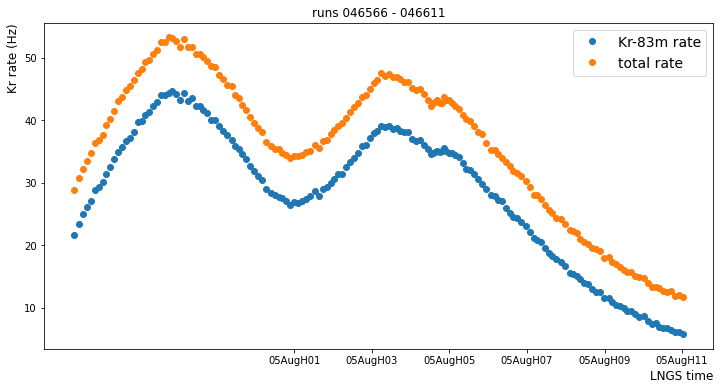

In [38]:
ddu.plot_kr_rate_vs_time(st,kr_runs0[26:42])

0
044399, livetime 1802.76 s, tot. events: 43133, Kr events: 31832, Kr-rate: 17.66 Hz
1
044396, livetime 1803.20 s, tot. events: 49317, Kr events: 37861, Kr-rate: 21.00 Hz
2
044393, livetime 1803.05 s, tot. events: 56808, Kr events: 44856, Kr-rate: 24.88 Hz
3
044390, livetime 1803.07 s, tot. events: 64963, Kr events: 52607, Kr-rate: 29.18 Hz
4
044387, livetime 1803.33 s, tot. events: 72846, Kr events: 60289, Kr-rate: 33.43 Hz
5
044384, livetime 1803.02 s, tot. events: 81462, Kr events: 68653, Kr-rate: 38.08 Hz
6
044381, livetime 1803.17 s, tot. events: 89629, Kr events: 76796, Kr-rate: 42.59 Hz
7
044378, livetime 1802.97 s, tot. events: 96172, Kr events: 82883, Kr-rate: 45.97 Hz
8
044375, livetime 1803.03 s, tot. events: 103120, Kr events: 89380, Kr-rate: 49.57 Hz
9
044372, livetime 1803.09 s, tot. events: 104637, Kr events: 90567, Kr-rate: 50.23 Hz
10
044369, livetime 1803.10 s, tot. events: 105718, Kr events: 92110, Kr-rate: 51.08 Hz
11
044366, livetime 383.12 s, tot. events: 23321, 

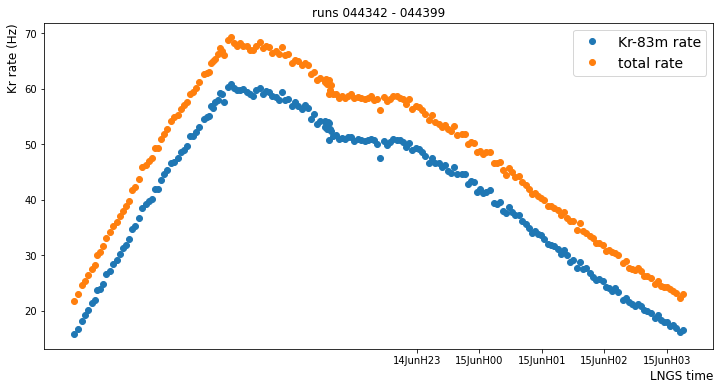

In [40]:
ddu.plot_kr_rate_vs_time(st,kr_runs1[45:65])

In [16]:
ddir = '/dali/lgrandi/dandrea/data'
#evKr0 = ddu.merge_runs_kr(st,kr_runs0[26:42])
#evKr0.to_pickle(f'{ddir}/SR1_dev_Kr83m_{kr_runs0[42]}_{kr_runs0[26]}_EventInfoDouble.pkl')
evKr0 = pd.read_pickle(f'{ddir}/SR1_dev_Kr83m_{kr_runs0[42]}_{kr_runs0[26]}_EventInfoDouble.pkl')

In [17]:
#evKr1 = ddu.merge_runs_double(st,kr_runs1[45:55])
#evKr1.to_pickle(f'{ddir}/SR1_dev_Kr83m_{kr_runs1[45]}_{kr_runs1[55]}_EventInfoDouble.pkl')
evKr1 = pd.read_pickle(f'{ddir}/SR1_dev_Kr83m_{kr_runs1[45]}_{kr_runs1[55]}_EventInfoDouble.pkl')

In [86]:
def diffusion_analysis_kr(ev, title = 'Kr83m', fit_range = (50,2000), far = True, plot = False,
                          sr0 = False, name = None):
    #if(plot): ddu.plot_area_width_aft(ev, title)
    
    ######### Kr selection #########
    if sr0:
        KrSelection = st.get_single_plugin('030000', 'cut_Kr_SingleS1S2')
        mask = KrSelection.cut_by(ev)
    else: mask = ddu.mask_KrSingleS1(ev)
    
    ######### Perpendicular Wires selection #########
    #FarWires = st.get_single_plugin('030000', 'cut_far_wires')
    #NearWires = st.get_single_plugin('030000', 'cut_near_wires')
    #maskFW = FarWires.cut_by(ev)
    #maskNW = NearWires.cut_by(ev)
    maskFW, maskNW = wcu.mask_S2Width_vs_pos_kr(ev)
    if far: evD = ev[mask & maskFW]
    else: evD = ev[mask & maskNW]
    #maskFV = ev['cut_fiducial_volume']
    #maskFV = ddu.mask_FV(ev)
    if(plot):
        ddu.plot_s2width_dt_kr(evD, title,width='90p',wlim = (0,30000),name=name)
        ddu.plot_s2width_dt_kr(evD, title,width='90p',tlim = (0,200), name=name+'z',wlim = (0,7000))
    #    ddu.plot_area_width_aft_kr(evD, title)
    #    wcu.plot_r2z_xy(evD,title)
    vd, vd_err, cathodedt, gatedt, s2shift = ddu.drift_velocity_kr(evD,title,name=name,
                                                                   binning=2000,w=4,plot=plot)
    d, d_err, par, par_err = ddu.diffusion_constant_kr(evD,title,fit_range=fit_range,vd=vd,
                                                       plot=plot,name=name)
    #return vd, vd_err, d, d_err, cathodedt, gatedt, s2shift, par, par_err
    par = (d* units.cm**2 / units.s,vd* units.mm / units.us,gatedt*units.us)
    return par

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity = 0.678 +/- 0.003 mm/us


/home/valerioda/xenon-notes/fast_response_analysis/drift_diffusion_utility.py:392: RuntimeWarning: invalid value encountered in sqrt
  


Diffusion constant = 47.01 +/- 0.13 cm2/s, tGate = 19.70 us


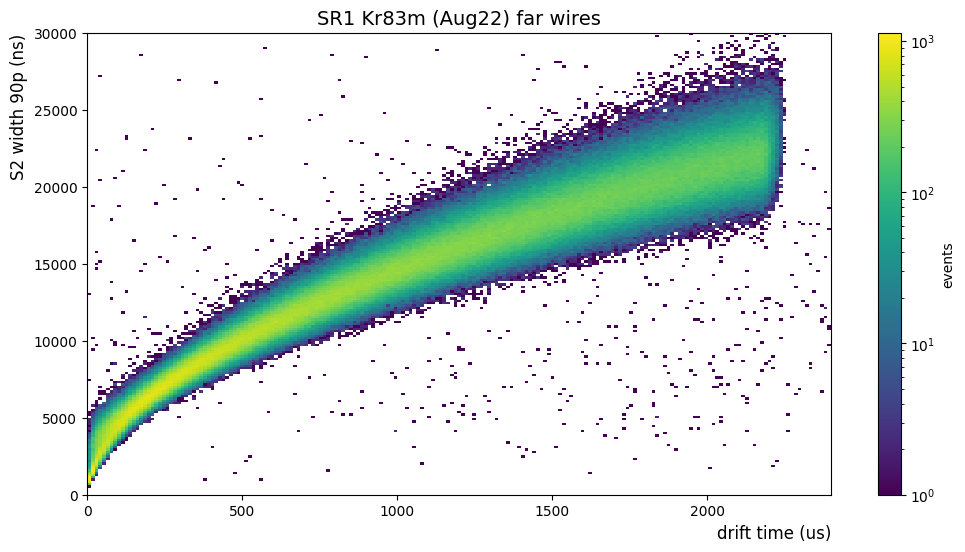

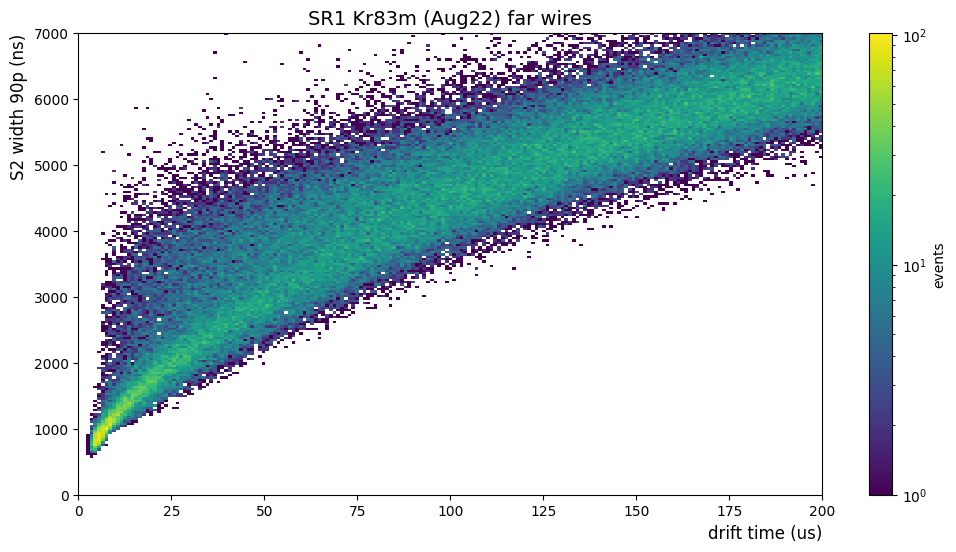

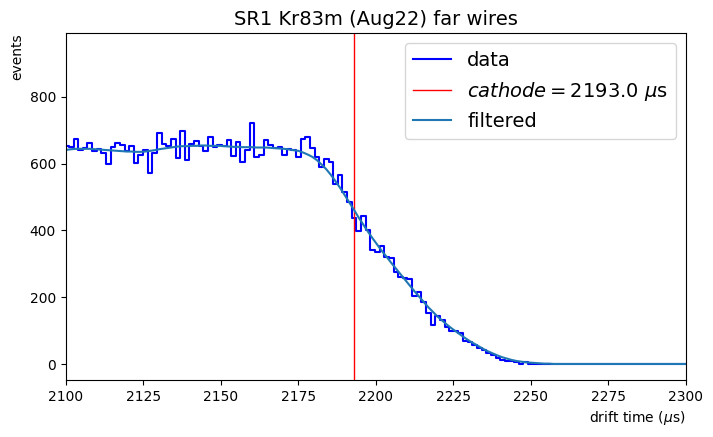

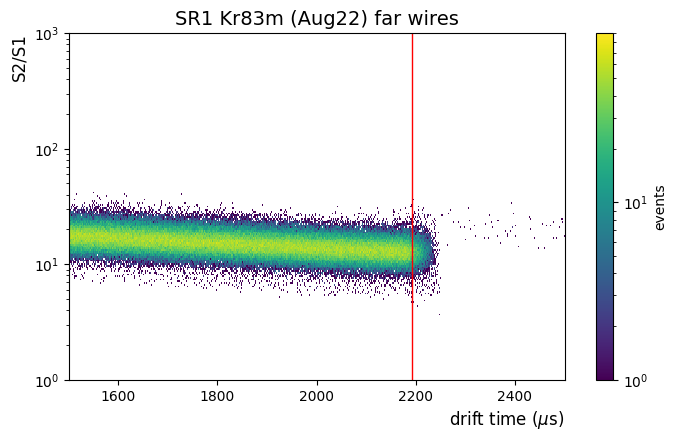

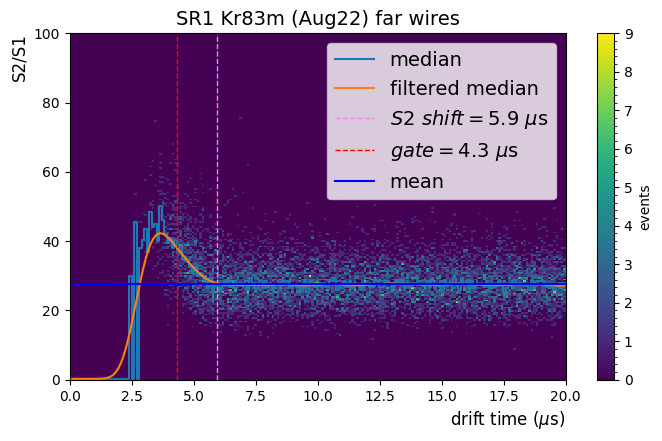

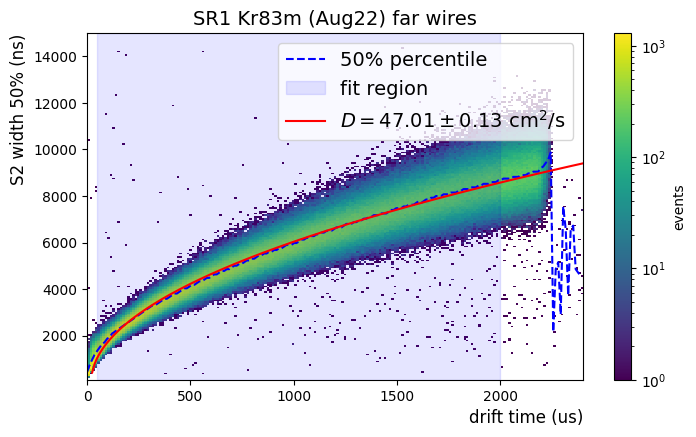

In [92]:
par=diffusion_analysis_kr(evKr0, title = 'SR1 Kr83m (Aug22) far wires',plot=1,name='sr1_kr83m_aug22_fw')

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity = 0.677 +/- 0.003 mm/us


/home/valerioda/xenon-notes/fast_response_analysis/drift_diffusion_utility.py:392: RuntimeWarning: invalid value encountered in sqrt
  


Diffusion constant = 52.09 +/- 0.18 cm2/s, tGate = 23.34 us


(5.2090497182188053e-08, 6.772623644929514e-05, 5628.140703517588)

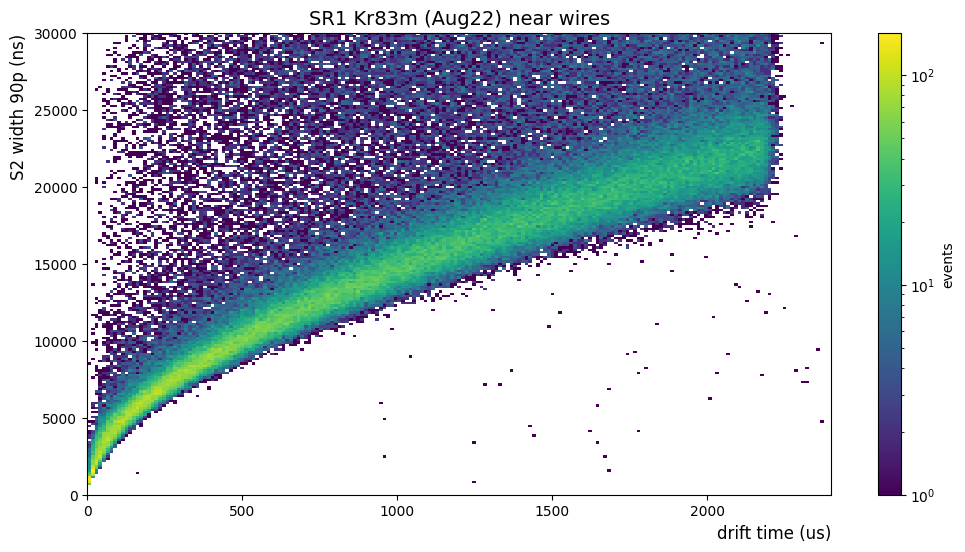

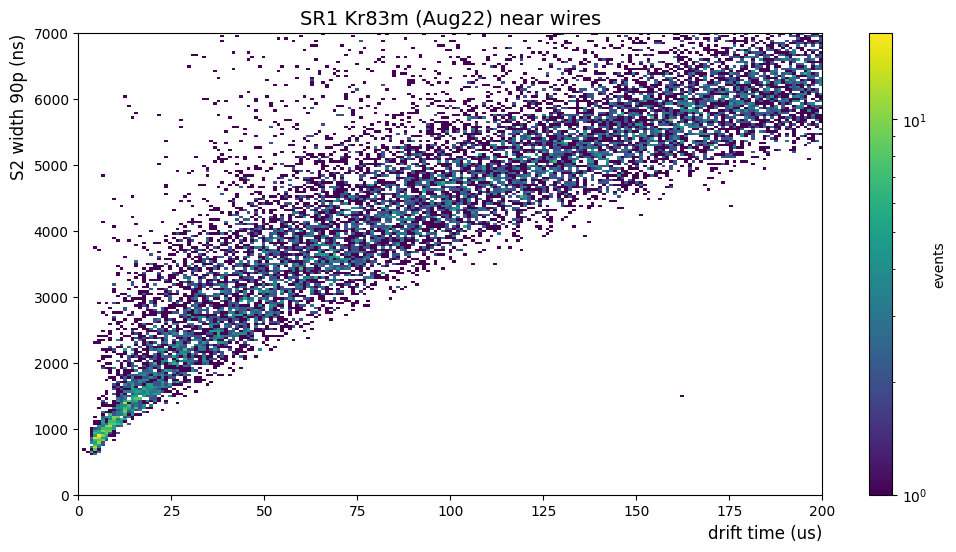

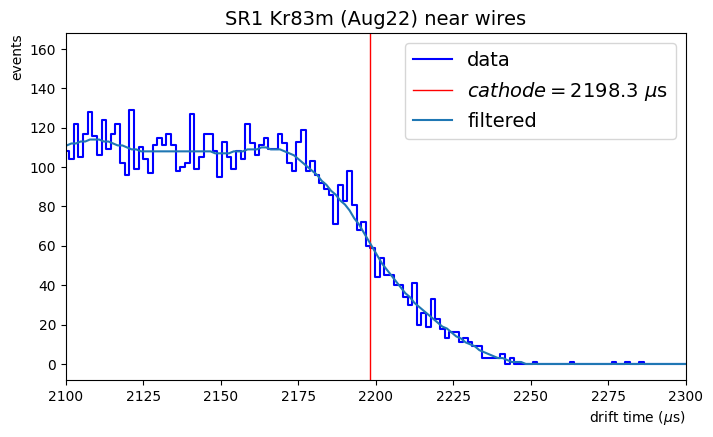

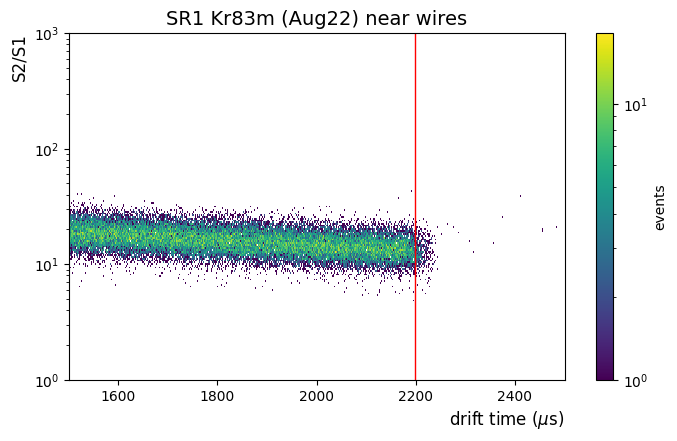

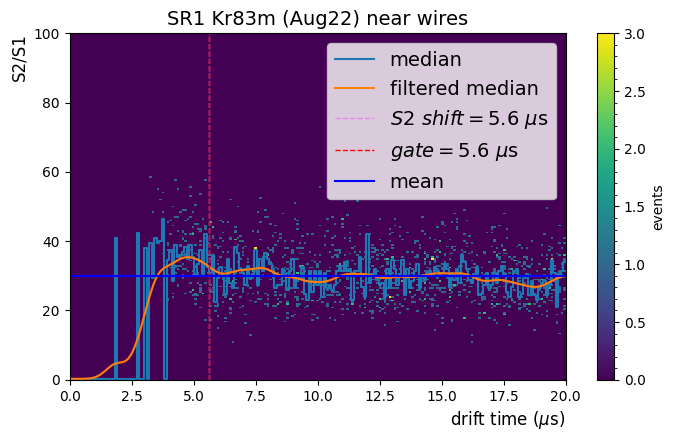

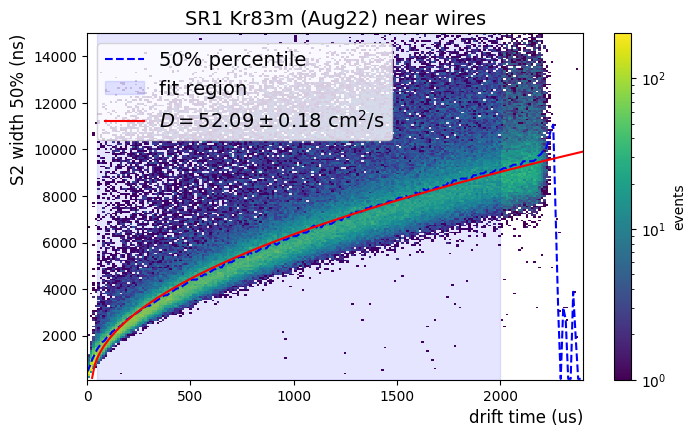

In [93]:
diffusion_analysis_kr(evKr0, title = 'SR1 Kr83m (Aug22) near wires',plot=1,far=0)

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity = 0.677 +/- 0.003 mm/us


/home/valerioda/xenon-notes/fast_response_analysis/drift_diffusion_utility.py:392: RuntimeWarning: invalid value encountered in sqrt
  


Diffusion constant = 46.33 +/- 0.13 cm2/s, tGate = 18.34 us


(4.632599242930811e-08, 6.769830922713626e-05, 4723.618090452262)

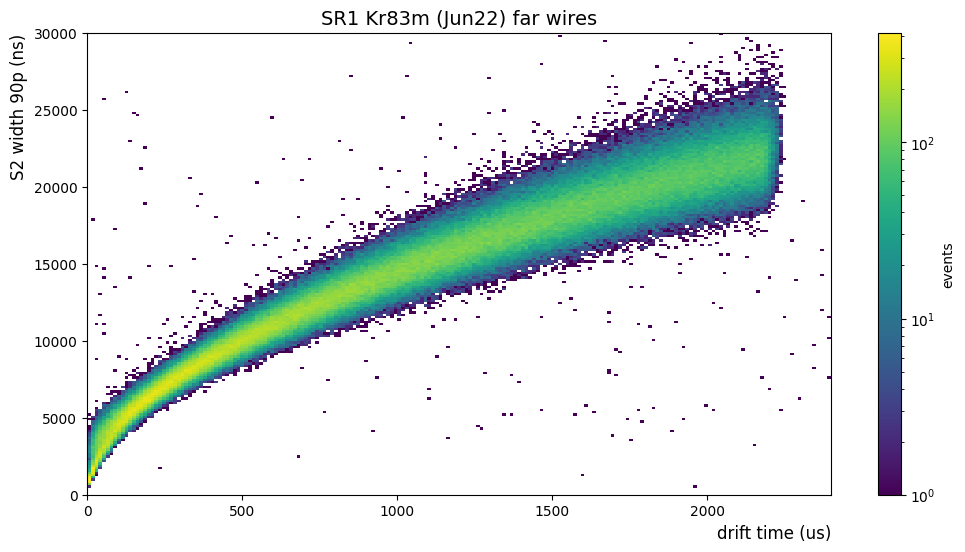

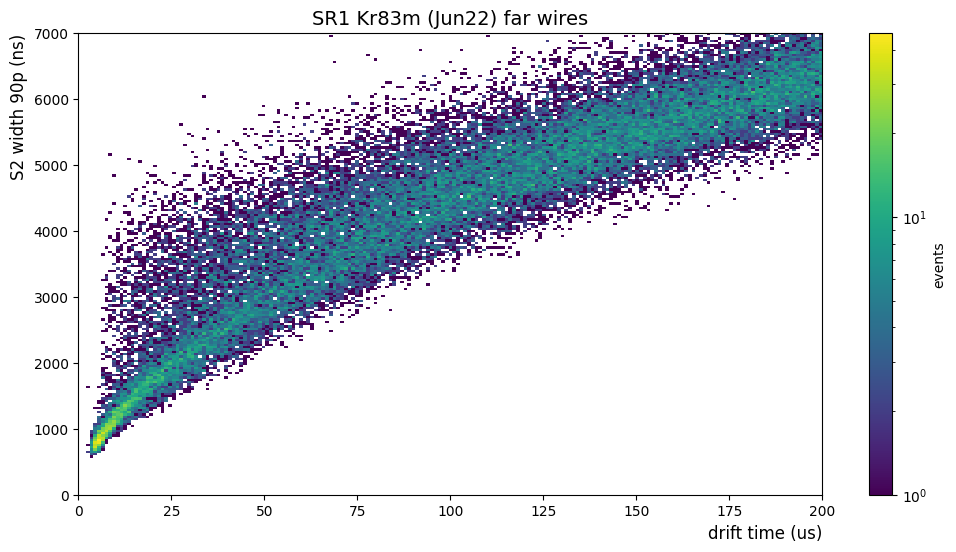

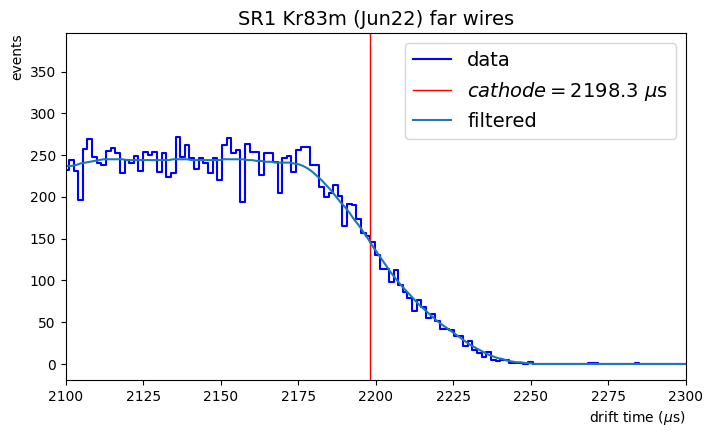

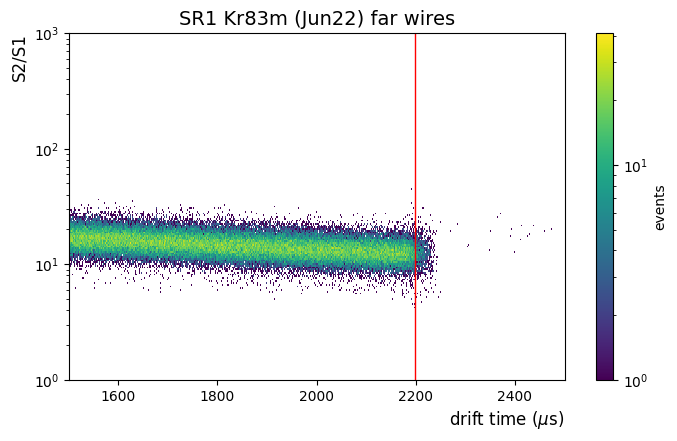

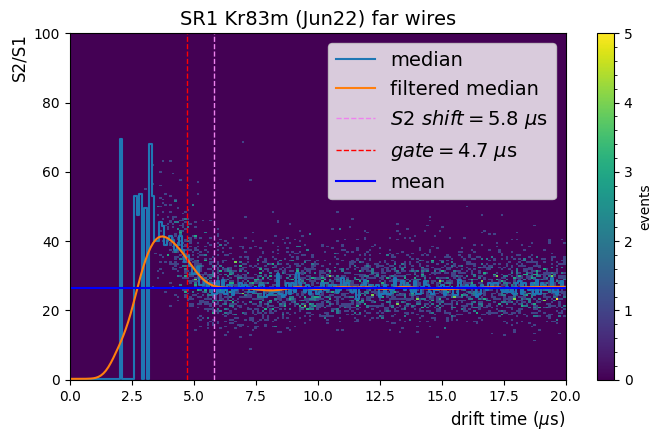

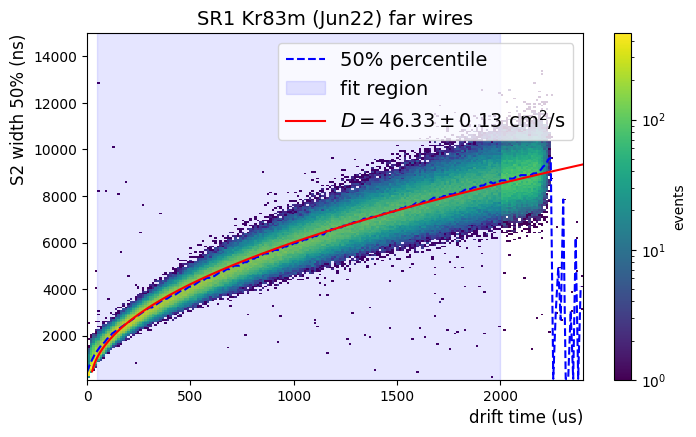

In [94]:
diffusion_analysis_kr(evKr1, title = 'SR1 Kr83m (Jun22) far wires',plot=1,name='sr1_kr83m_jun22_fw')

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity = 0.685 +/- 0.003 mm/us


/home/valerioda/xenon-notes/fast_response_analysis/drift_diffusion_utility.py:392: RuntimeWarning: invalid value encountered in sqrt
  


Diffusion constant = 52.94 +/- 0.18 cm2/s, tGate = 23.68 us


(5.2935465290124325e-08, 6.850325293664556e-05, 17286.432160804023)

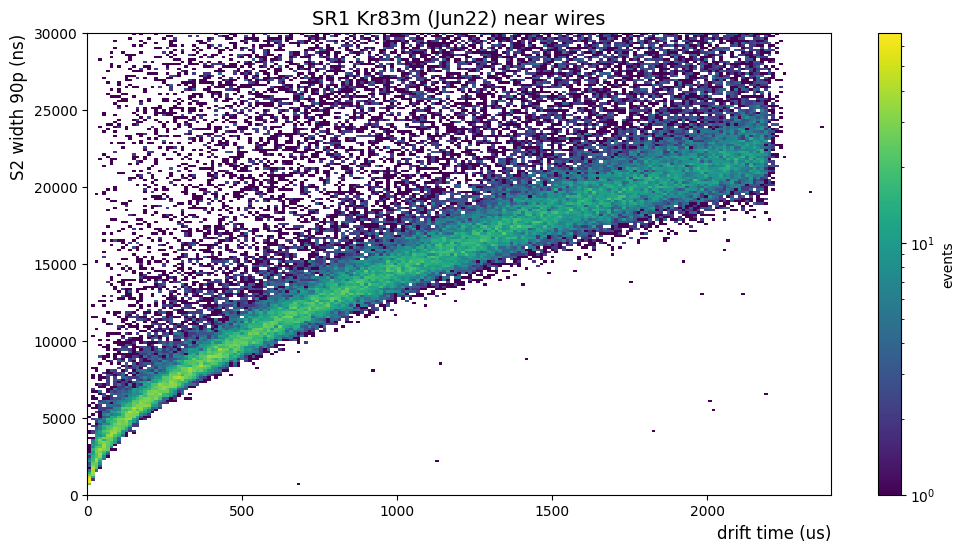

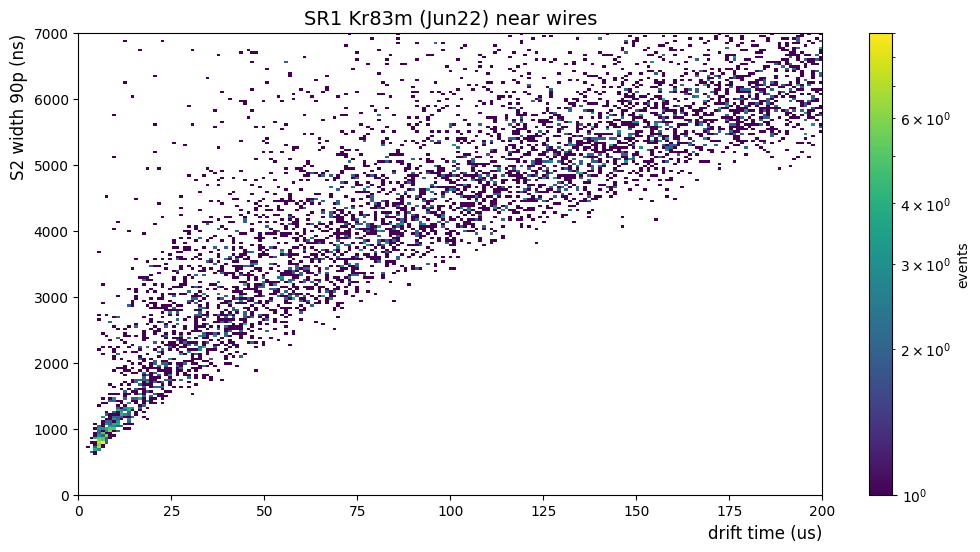

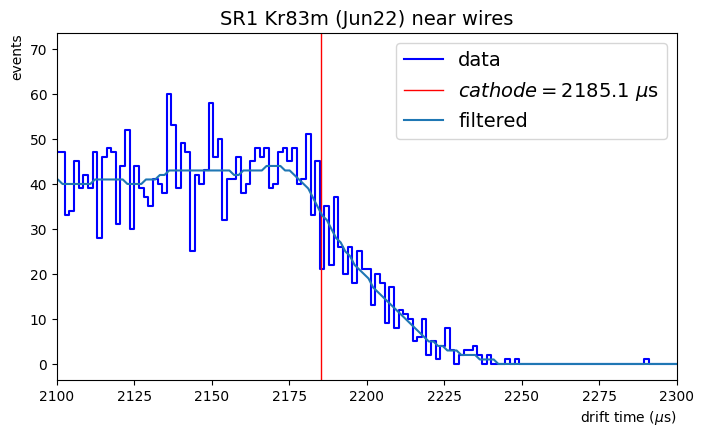

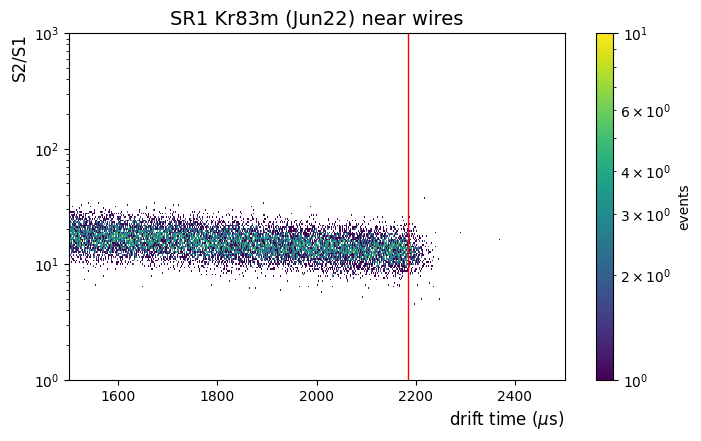

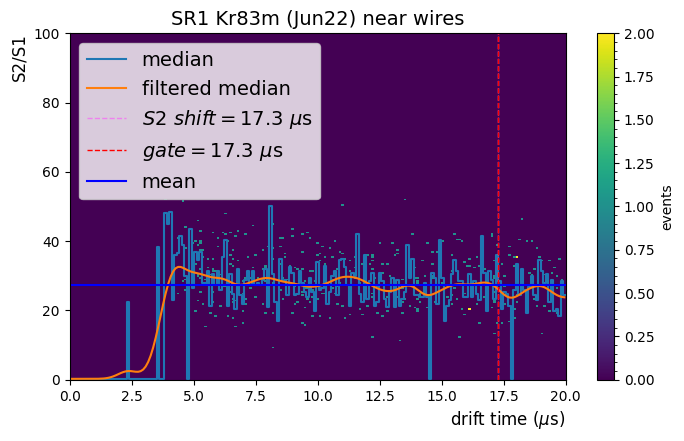

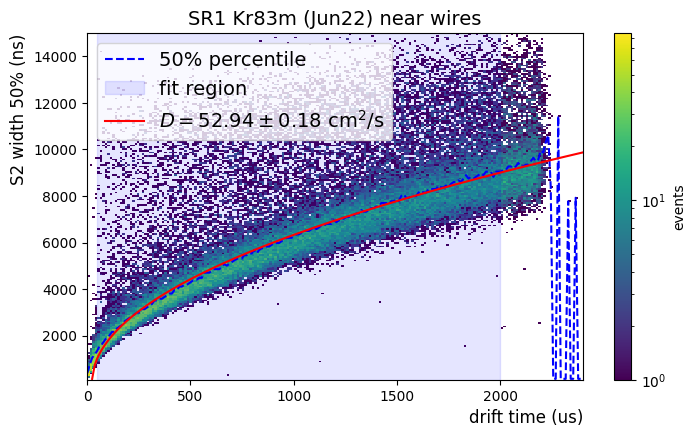

In [95]:
diffusion_analysis_kr(evKr1, title = 'SR1 Kr83m (Jun22) near wires',plot=1,far=0)

In [77]:
evKr_sr0 = pd.read_pickle(f'{ddir}/SR0_v8_Kr83m_021479_021521_EventInfoDouble.pkl') 

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity = 0.674 +/- 0.003 mm/us


/home/valerioda/xenon-notes/fast_response_analysis/drift_diffusion_utility.py:392: RuntimeWarning: invalid value encountered in sqrt
  


Diffusion constant = 45.67 +/- 0.13 cm2/s, tGate = 15.15 us


(4.5671048386953186e-08, 6.74422866525675e-05, 4623.115577889448)

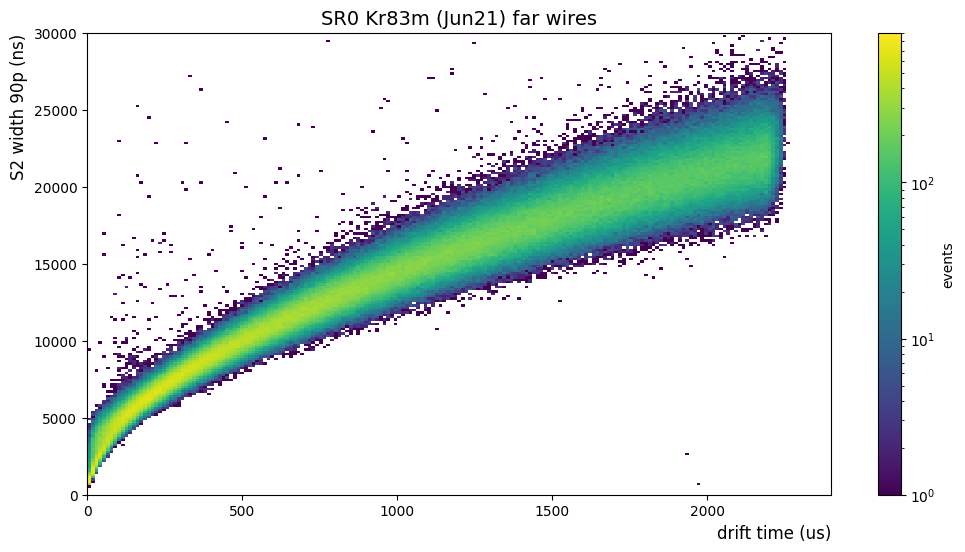

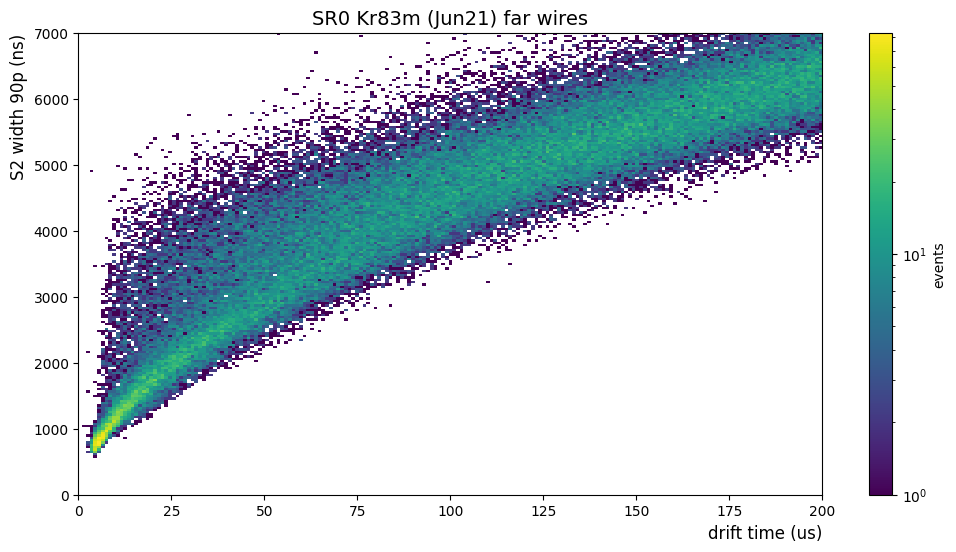

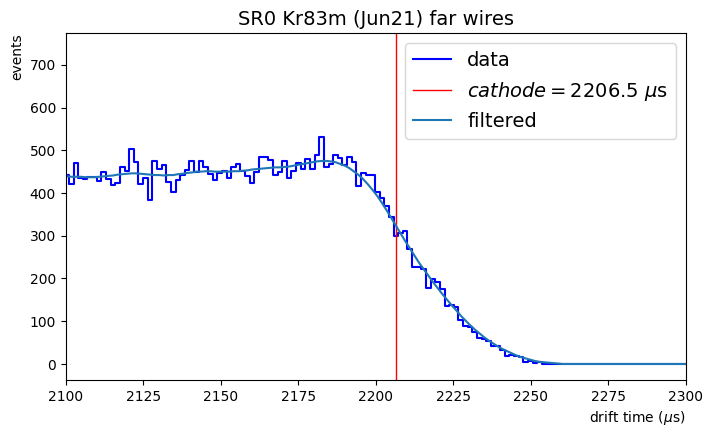

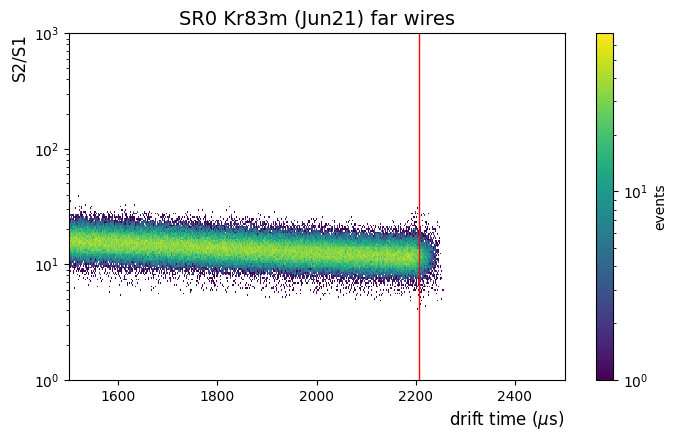

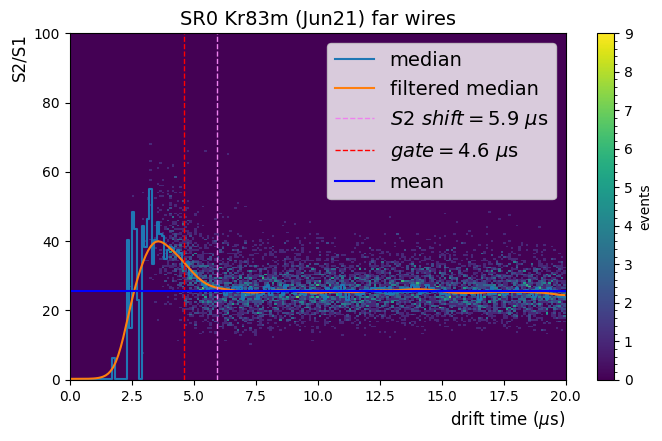

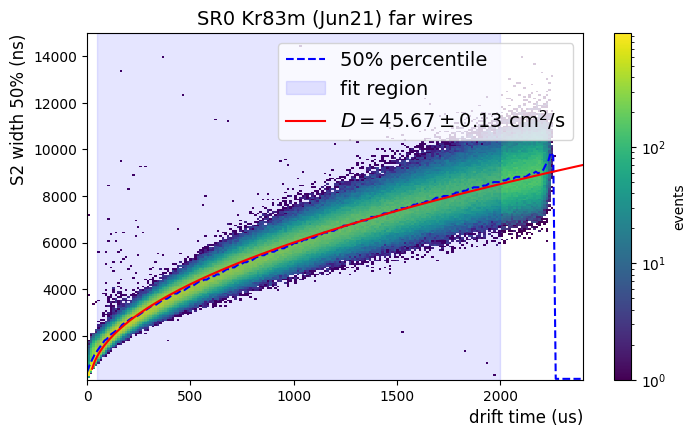

In [96]:
diffusion_analysis_kr(evKr_sr0,title='SR0 Kr83m (Jun21) far wires',plot=1,name='sr0_kr83m_jun21_fw',sr0=1)

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Drift velocity = 0.676 +/- 0.003 mm/us


/home/valerioda/xenon-notes/fast_response_analysis/drift_diffusion_utility.py:392: RuntimeWarning: invalid value encountered in sqrt
  


Diffusion constant = 48.84 +/- 0.14 cm2/s, tGate = 16.60 us


(4.8844131837712365e-08, 6.761229750457772e-05, 4924.62311557789)

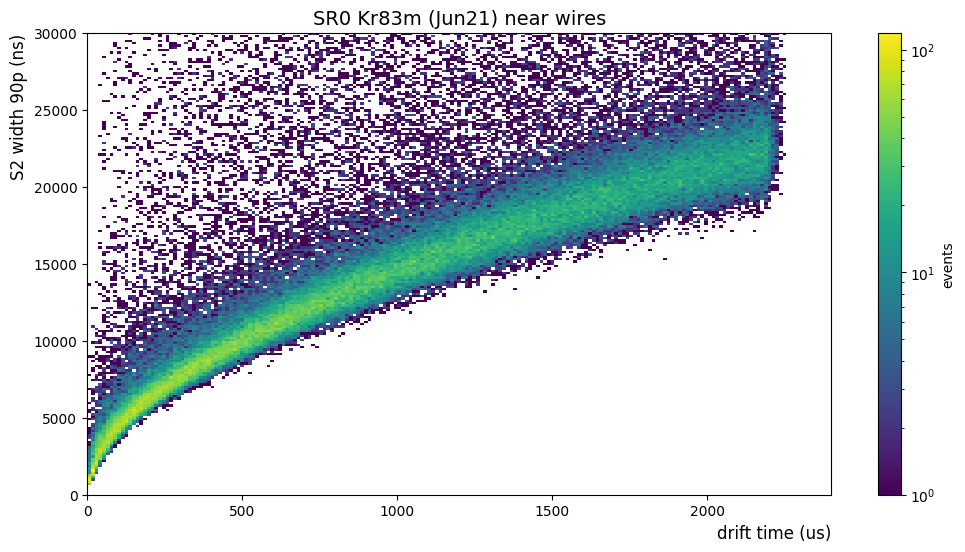

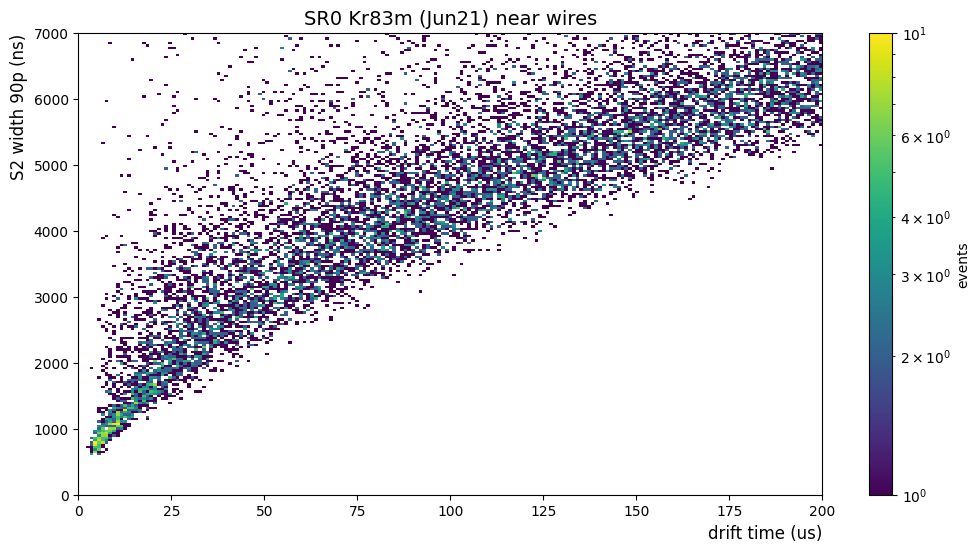

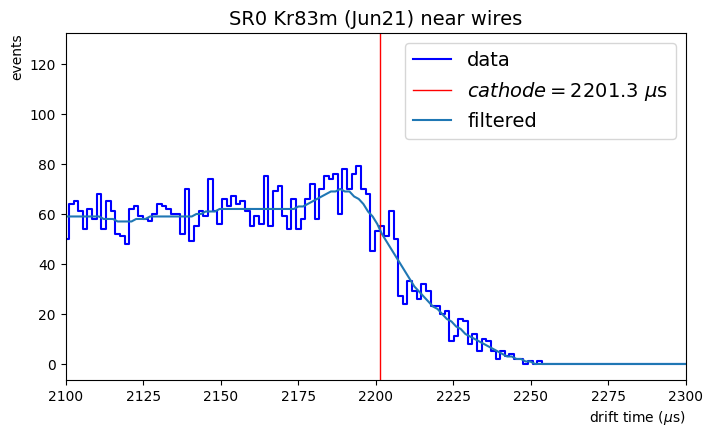

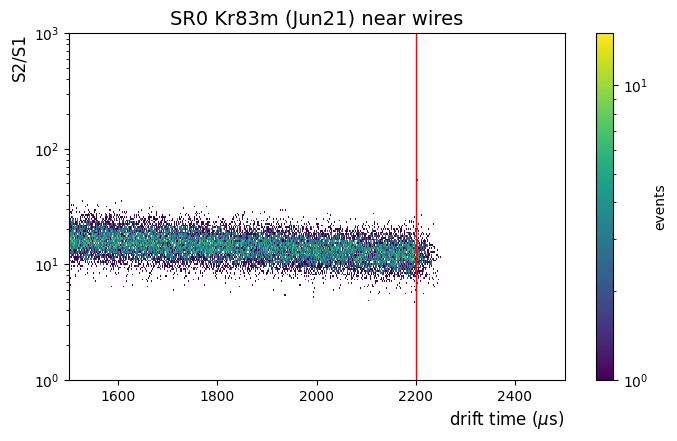

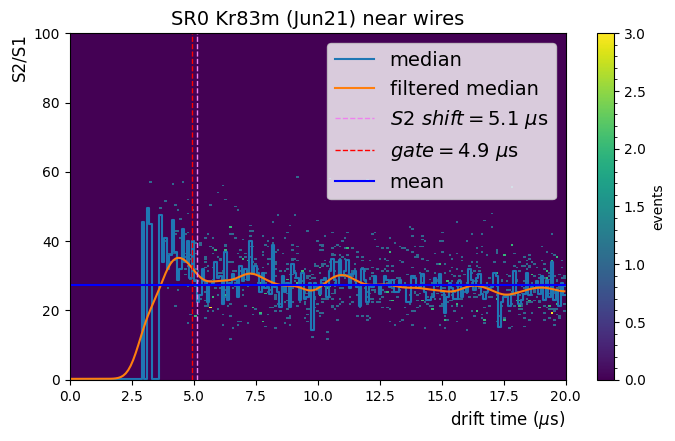

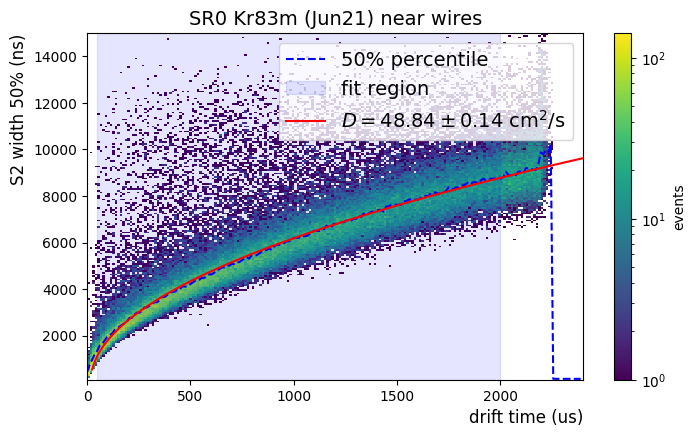

In [97]:
diffusion_analysis_kr(evKr_sr0,title='SR0 Kr83m (Jun21) near wires',plot=1,far=0,sr0=1)

# S2 Width Cut

In [20]:
# FAR FROM WIRES 1-99%
cut_far = (( 0.75785949 , 3.18263529 , 1.26349891 ),
          ( 4.74467848 , 1.34106577 , 1.99650474 , 1.02559667 ))
# NEAR WIRES 5-99%
cut_near = (( 0.7742574 , 2.92714807 , 1.22338626 ),
           ( 4.74467848 , 1.34106577 , 1.99650474 , 1.02559667 ))

In [21]:
vd = get_correction_from_cmt('024075',('electron_drift_velocity', 'ONLINE', True))
gd = get_correction_from_cmt('024075',('electron_drift_time_gate', 'ONLINE', True))
dc = get_correction_from_cmt('024075',('electron_diffusion_cte', 'ONLINE', True))
par = (dc,vd,gd)
print(par)

(4.566e-08, 6.77e-05, 2700.0)


In [68]:
def apply_cut(events, title = 'Kr-83m', near = True):
    mask = ddu.mask_KrSingleS1(events)
    maskFW, maskNW = wcu.mask_S2Width_vs_pos_kr(events)
    if near: ev = events[mask & maskNW]
    else: ev = events[mask & maskFW]
    cut_mask_kr = wcu.S2WidthCut(ev, title=title, mod_par=par, bins=400,
                             wrange=(0,3),arange=(3.2,4.5), plot = 1, perc_plot=0,
                             ext_par=cut_far, near_wires=near, wire_model=0,kr=1 )
    acc_kr = wcu.get_acceptance_kr(ev, cut_mask_kr[1], title=title, alim=(0.8,1))

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634786 0.19632401]
param_parabola_high: [ 0.12086553 -1.2295208   4.37596581]
Cut: total 1047037, survived 1004828 -> 95.97%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2wid

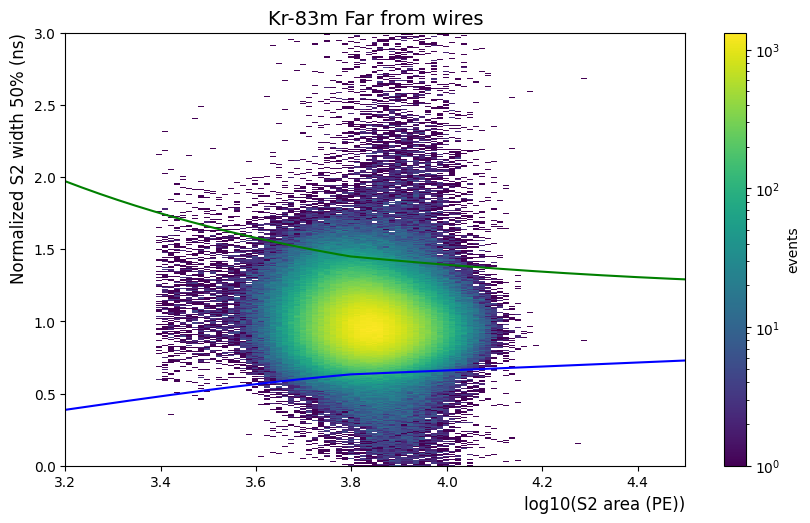

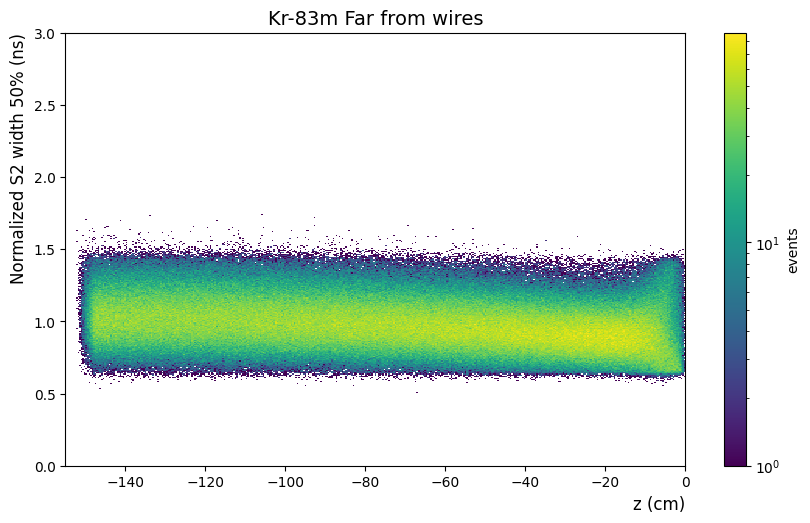

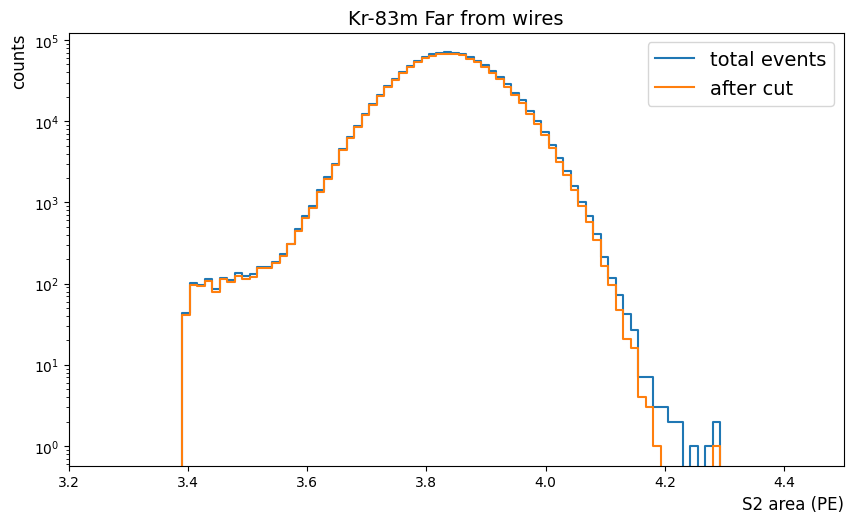

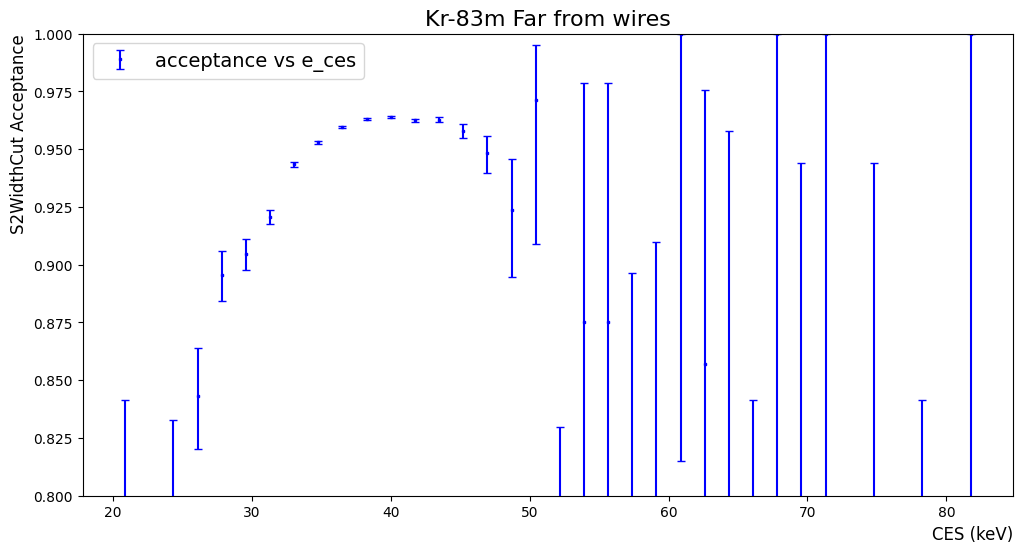

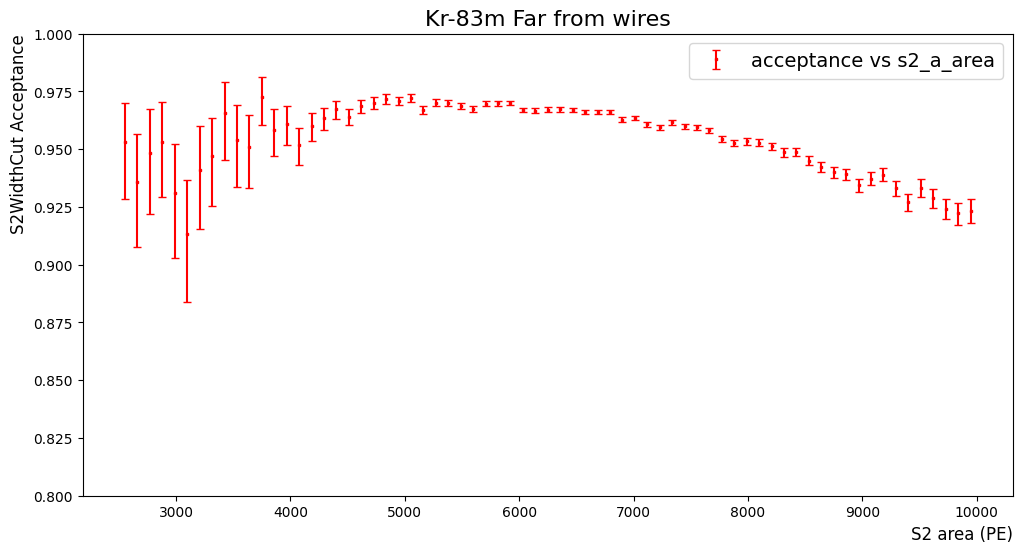

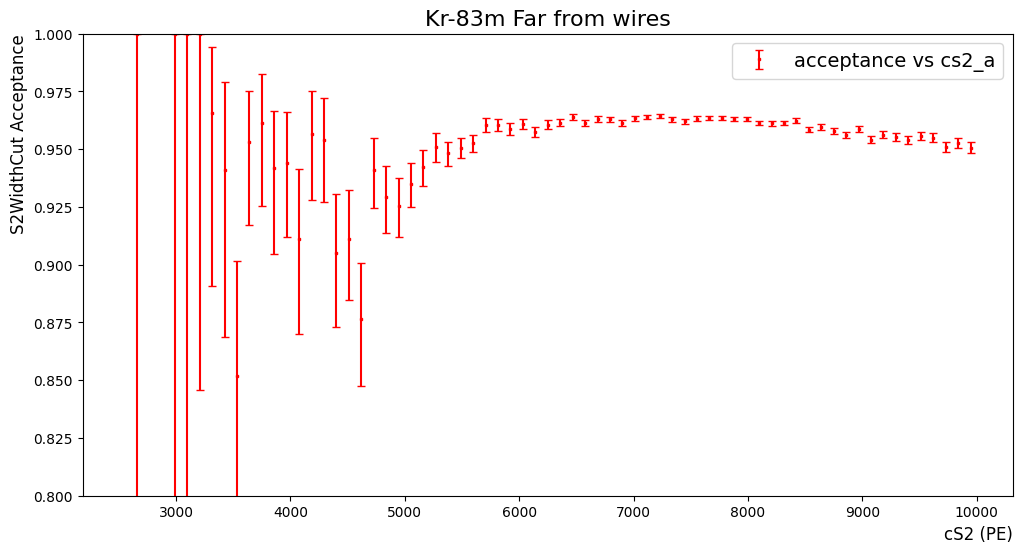

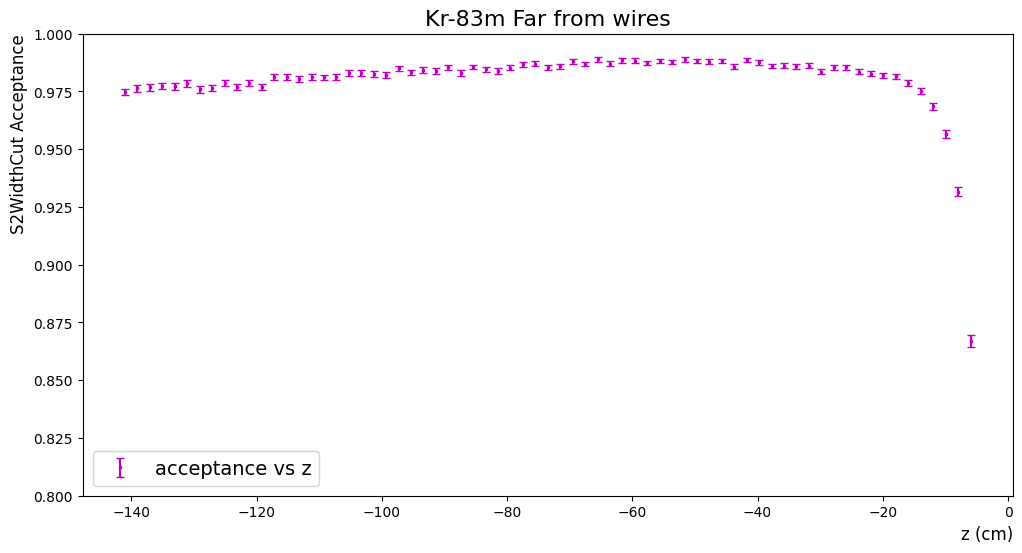

In [66]:
apply_cut(evKr0, title = 'Kr-83m Far from wires', near = 0)

Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634786 0.19632401]
param_parabola_high: [ 0.12086553 -1.2295208   4.37596581]
Cut: total 169366, survived 166100 -> 98.07%


/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/.local/lib/python3.8/site-packages/multihist-0.6.5-py3.8.egg/multihist.py:106: RuntimeWarning: invalid value encountered in true_divide
  getattr(self.histogram, opname)(other),
/home/valerioda/xenon-notes/fast_response_analysis/s2widthcut_utility.py:757: RuntimeWarning: invalid value encountered in long_scalars
  avg = k / n
/home/valerioda/xenon-notes/fast_response_analysis/s2wid

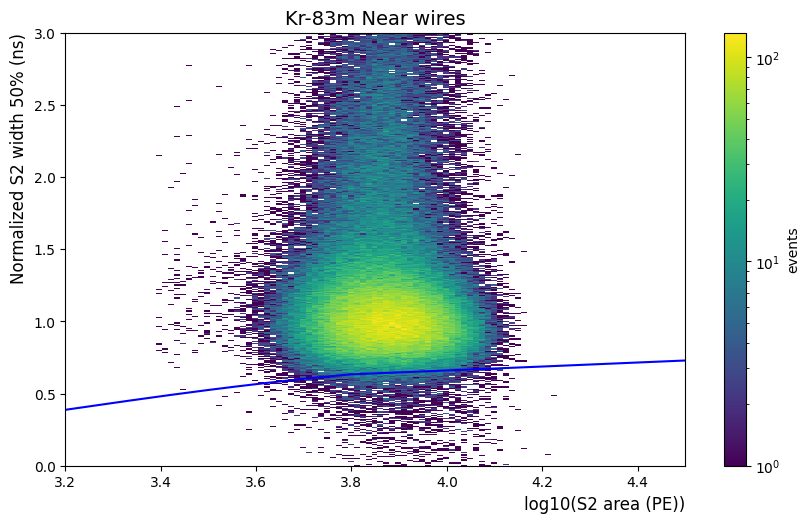

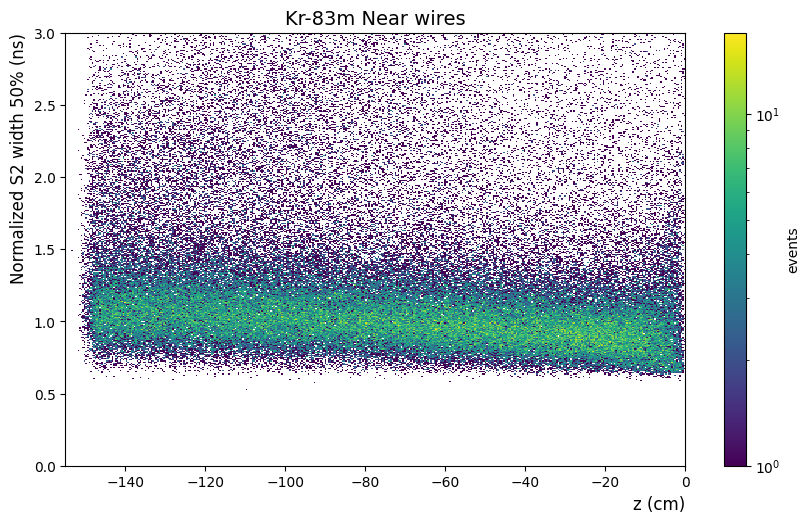

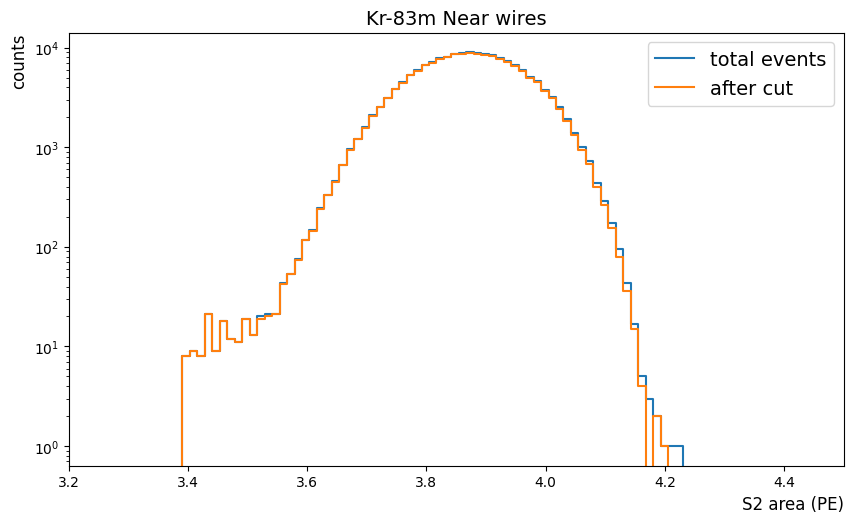

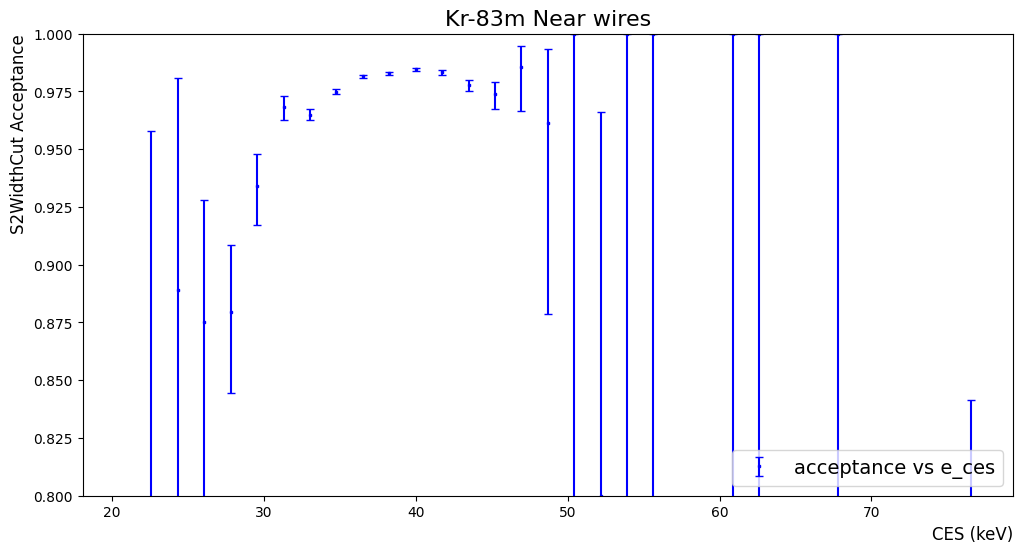

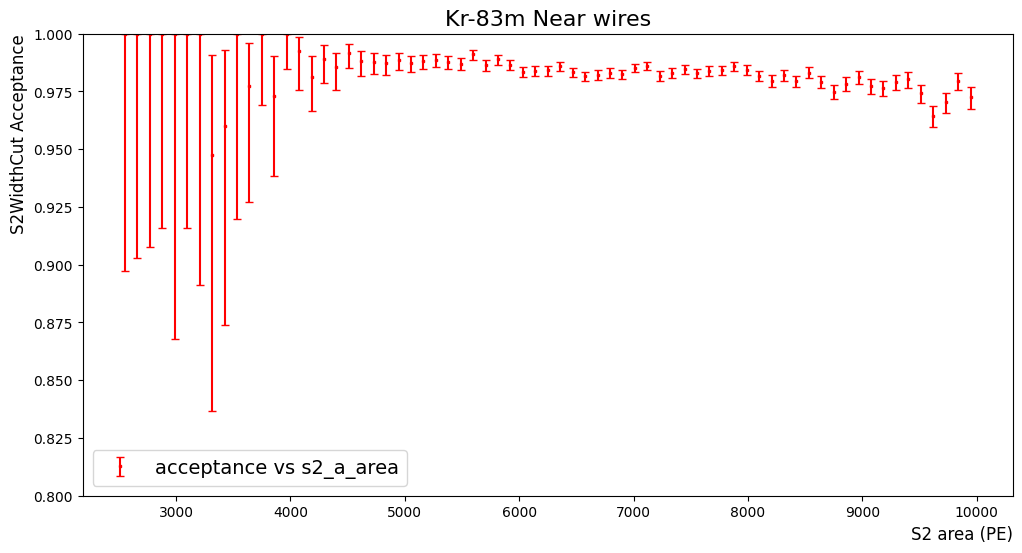

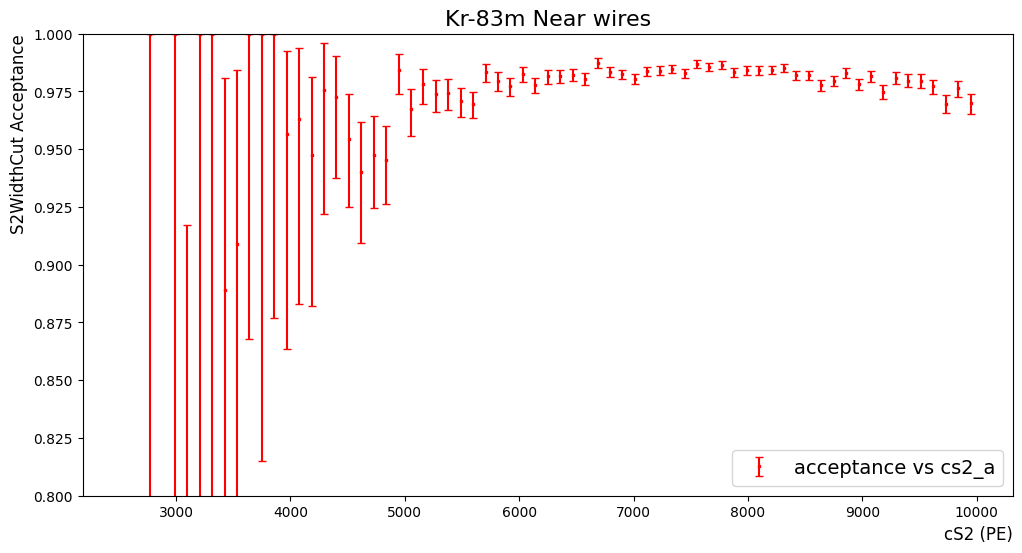

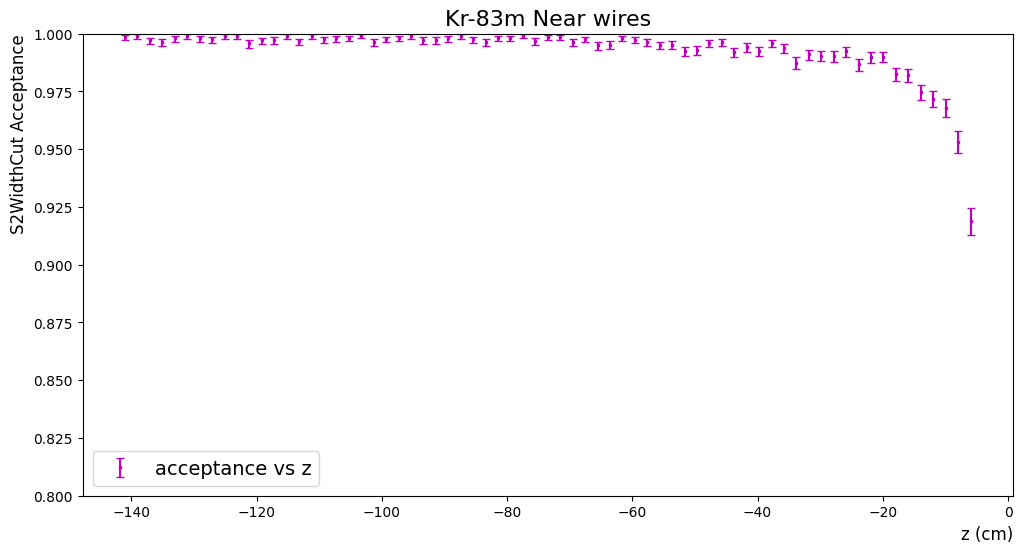

In [69]:
apply_cut(evKr0, title = 'Kr-83m Near wires', near = 1)

# BACKGROUND STUDY

In [7]:
dsets = st.select_runs(run_mode='background_linked',available='event_info',
                       exclude_tags=('bad','messy','hot_spot','ramp_up'))

In [8]:
dsets0 = dsets[(dsets.end > pd.to_datetime('07/25/2022')) & (dsets.end < pd.to_datetime('08/07/2022'))]
dsets1 = dsets[(dsets.end > pd.to_datetime('05/01/2022')) & (dsets.end < pd.to_datetime('07/01/2022'))]

In [9]:
bkg_runs0 = dsets0.name.values[:]
bkg_runs1 = dsets1.name.values[:]
print(len(bkg_runs0), len(bkg_runs1))

101 780


In [10]:
ddir = '/dali/lgrandi/dandrea/data'
#evbkg0 = ddu.merge_runs(st,bkg_runs0[:])
#evbkg0.to_pickle(f'{ddir}/SR0_bkg_{bkg_runs0[0]}_{bkg_runs0[-1]}_EventInfo.pkl')
evbkg0 = pd.read_pickle(f'{ddir}/SR0_bkg_{bkg_runs0[0]}_{bkg_runs0[-1]}_EventInfo.pkl')

In [12]:
#evbkg1 = ddu.merge_runs(st,bkg_runs1[:500])
#evbkg1.to_pickle(f'{ddir}/SR0_bkg_{bkg_runs1[0]}_{bkg_runs1[500]}_EventInfo.pkl')
evbkg1 = pd.read_pickle(f'{ddir}/SR0_bkg_{bkg_runs1[0]}_{bkg_runs1[500]}_EventInfo.pkl')

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


total events 369821
Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634786 0.19632401]
param_parabola_high: [ 0.12086553 -1.2295208   4.37596581]
Cut: total 369821, survived 247819 -> 67.01%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


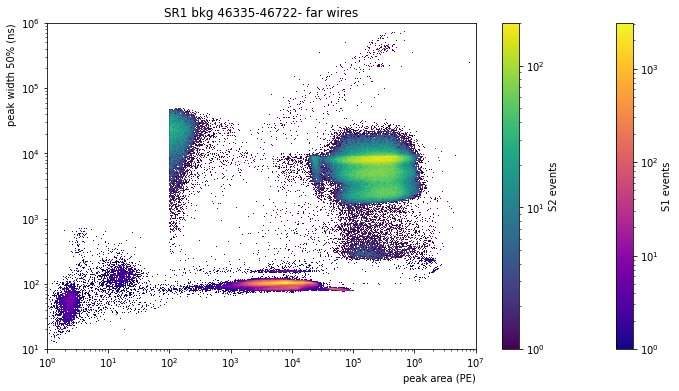

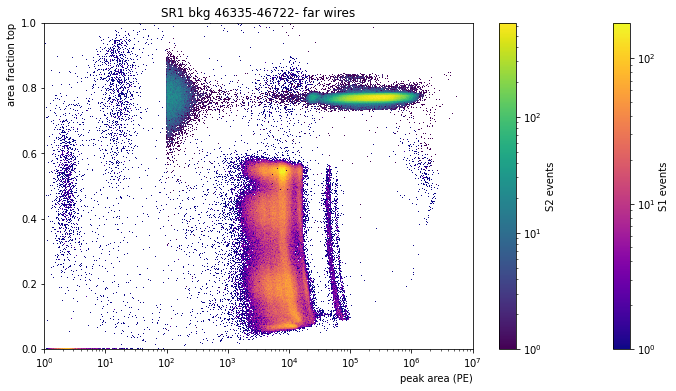

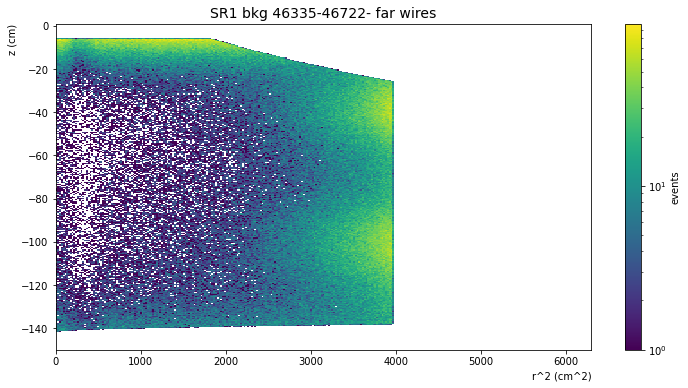

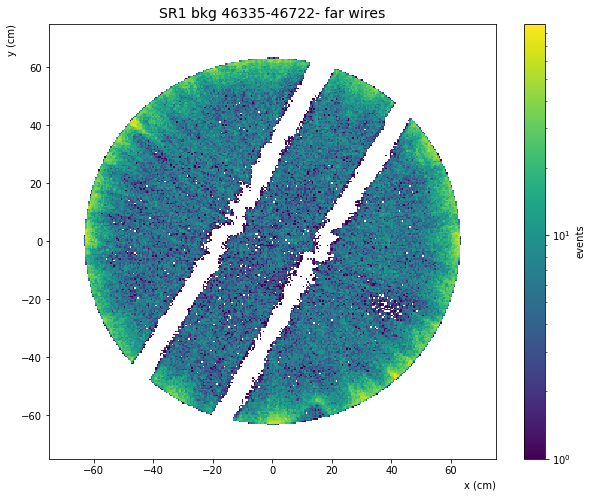

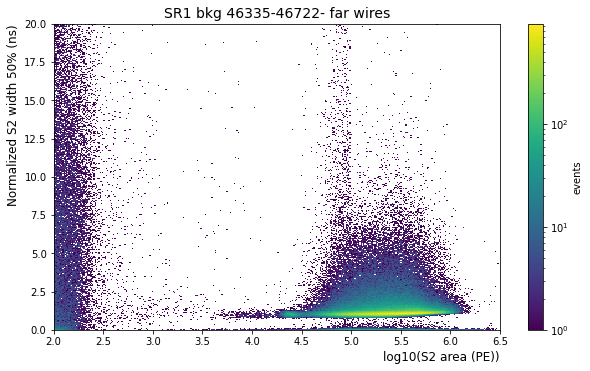

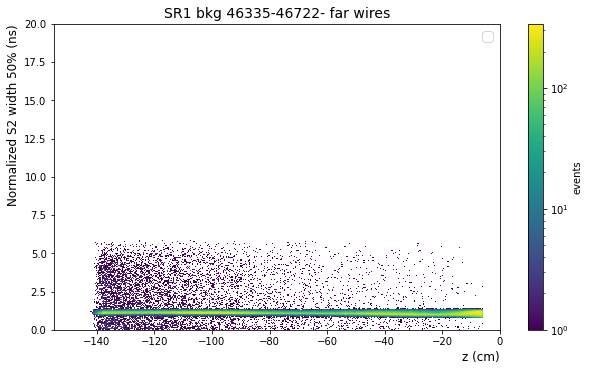

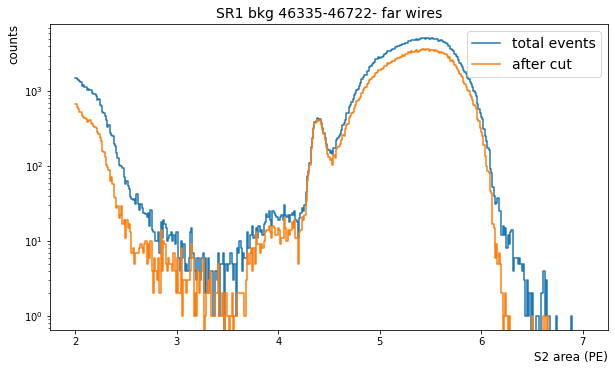

In [22]:
fit_par = (( 0.75785949,3.18263529,1.26349891), ( 4.74467848,1.34106577,1.99650474,1.02559667 ))
maskFW, maskNW = wcu.mask_S2Width_vs_pos(evbkg0)
#maskFV = ddu.mask_FV(evbkg0)
FiducialVolume = st.get_single_plugin('030000', 'cut_fiducial_volume')
maskFV = FiducialVolume.cut_by(evbkg0)
evv0 = evbkg0[maskFW & maskFV]
title='SR1 bkg 46335-46722 far wires'
ddu.plot_area_width_aft(evv0, title)
wcu.plot_r2z_xy(evv0,title)
cut_ = wcu.S2WidthCut(evv0, title=title, mod_par=par, bins=400,ext_par=fit_par,
                      wrange=(0,20), arange = (2.,6.5), plot = 1, perc_plot=0)

/home/valerioda/.local/lib/python3.8/site-packages/pandas-1.4.2-py3.8-linux-x86_64.egg/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


total events 338926
Lower and higher boundary provided externally
param_parabola_low: [0.00487747 0.09634786 0.19632401]
param_parabola_high: [ 0.12086553 -1.2295208   4.37596581]
Cut: total 338926, survived 239575 -> 70.69%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


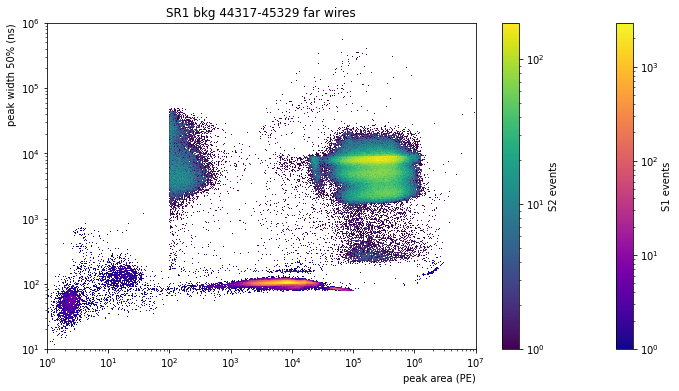

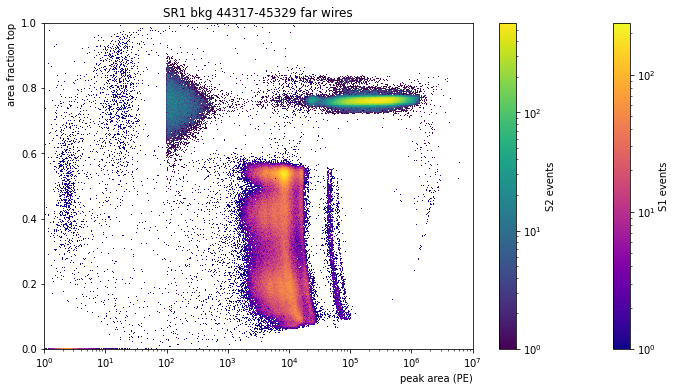

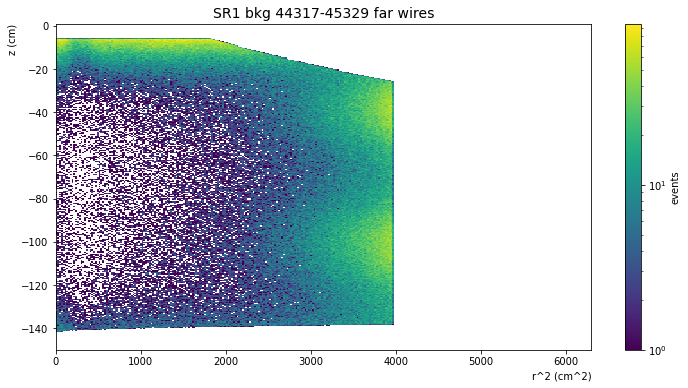

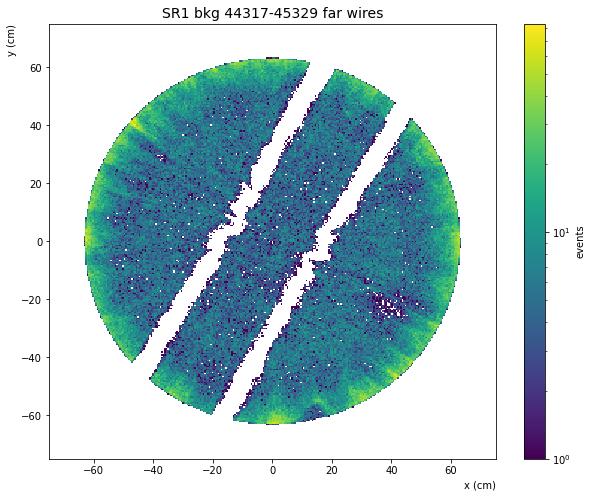

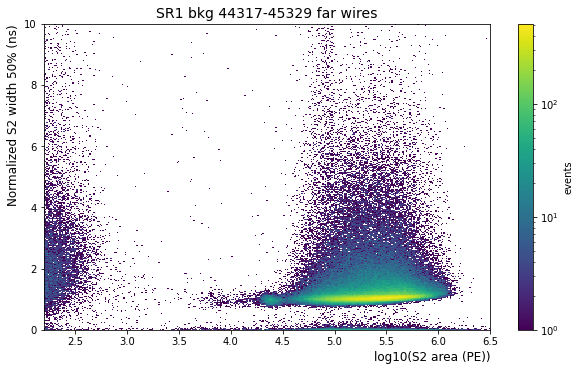

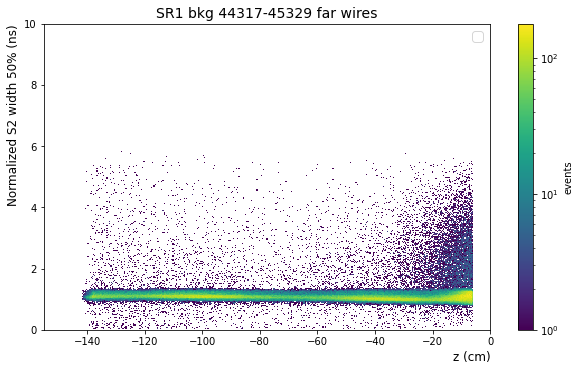

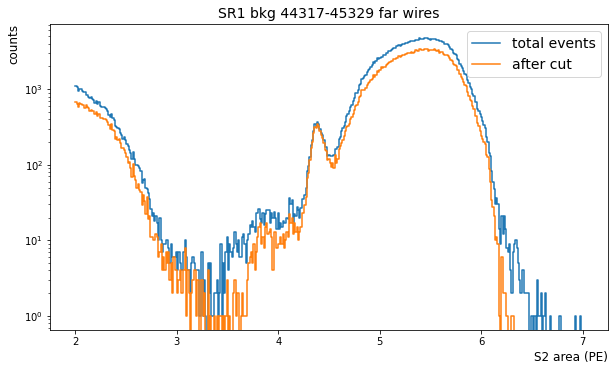

In [20]:
maskFW, maskNW = wcu.mask_S2Width_vs_pos(evbkg1)
maskFV = FiducialVolume.cut_by(evbkg1)
evv1 = evbkg1[maskFW & maskFV]
title='SR1 bkg 44317-45329 far wires'
ddu.plot_area_width_aft(evv1, title)
wcu.plot_r2z_xy(evv1,title)
cut_ = wcu.S2WidthCut(evv1, title=title, mod_par=par, bins=400,ext_par=fit_par,
                      wrange=(0,10), arange = (2.2,6.5), plot = 1, perc_plot=0)

In [36]:
import bokeh.plotting as bklt
from IPython.core.display import display, HTML
def display_events(st,run_id, nev = 1, area_cut=(1e2,1e7)):
    if (st.is_stored(run_id, ('event_info'))==False): return print('No events stored')
    ev0 = st.get_array(run_id,['event_info', 'cut_fiducial_volume'],progress_bar=False)
    maskFW, maskNW = wcu.mask_S2Width_vs_pos(ev0)
    mask = (ev0['s2_area'] > area_cut[0]) & (ev0['s2_area'] < area_cut[1])
    ev = ev0[maskFW & ev0['cut_fiducial_volume']]
    events = ev0[mask & maskFW & ev0['cut_fiducial_volume']]
    print('total events',len(ev0),'\nafter FV & far wires',len(ev),'\nafter area selection',len(events))
    for i in range(nev):
        idx = int(np.random.rand()*len(events))
        fig = st.event_display_interactive(run_id,
                                           time_range=(events[idx]['time'],
                                                       events[idx]['endtime']),
                                           bottom_pmt_array=False)
        bklt.show(fig)

/tmp/jobs/21986510/ipykernel_2671/2738366215.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [39]:
display_events(st,'046722', nev = 10, area_cut=(0,1e3))

total events 60065 
after FV & far wires 8708 
after area selection 784


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen/analyses/bokeh_waveform_plot.py:562: RuntimeWarning: divide by zero encountered in log10
  area_plot = np.log10(area_per_channel)
